# Standaryzacja mocy wg power curve

### Wczytanie bibliotek oraz danych:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
Power_curve = pd.read_csv('data/train/Power_curve.csv').set_index('Wind speed (m/s)')
signals = pd.read_csv('data/train/wind-farm-1-signals-training.csv', sep=';', parse_dates=['Timestamp'])
# Podział na zbiory dla każdej z turbin osobno, indeks czasowy
signals_T01 = signals[signals.Turbine_ID=='T01'].set_index('Timestamp')
signals_T06 = signals[signals.Turbine_ID=='T06'].set_index('Timestamp')
signals_T07 = signals[signals.Turbine_ID=='T07'].set_index('Timestamp')
signals_T09 = signals[signals.Turbine_ID=='T09'].set_index('Timestamp')
signals_T11 = signals[signals.Turbine_ID=='T11'].set_index('Timestamp')

### Czyszczenie danych


In [3]:
# Odrzucenie ujemnych wartości generowanego prądu
def maintain_positive(turbine):
    return turbine.loc[turbine["Grd_Prod_Pwr_Avg"] > 0, :]

signals_T01 = maintain_positive(signals_T01)
signals_T06 = maintain_positive(signals_T06)
signals_T07 = maintain_positive(signals_T07)
signals_T09 = maintain_positive(signals_T09)
signals_T11 = maintain_positive(signals_T11)

In [4]:
# Funkcja przycina dane do prędkości wiatru z zakresu [lower,uper]
def trim_wind(turbine, lower, uper):
    return turbine.loc[(turbine["Amb_WindSpeed_Avg"] < uper) & (turbine["Amb_WindSpeed_Avg"] > lower) , :]

### Standaryzacja 1.

Ciągłe przybliżenie power curve za pomocą interpolacji liniowej.

In [5]:
# Interpolacja liniowa względem Power_curve (działa dla wiatrów 4-25)
power_curve1 = interpolate.interp1d(Power_curve.index, Power_curve.iloc[:,0])

In [6]:
def std_power_curve1(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Std"] = turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] - power_curve1(turbine_new.loc[:,"Amb_WindSpeed_Avg"])
    return turbine_new

signals_T01_std = std_power_curve1(signals_T01)
signals_T06_std = std_power_curve1(signals_T06)
signals_T07_std = std_power_curve1(signals_T07)
signals_T09_std = std_power_curve1(signals_T09)
signals_T11_std = std_power_curve1(signals_T11)

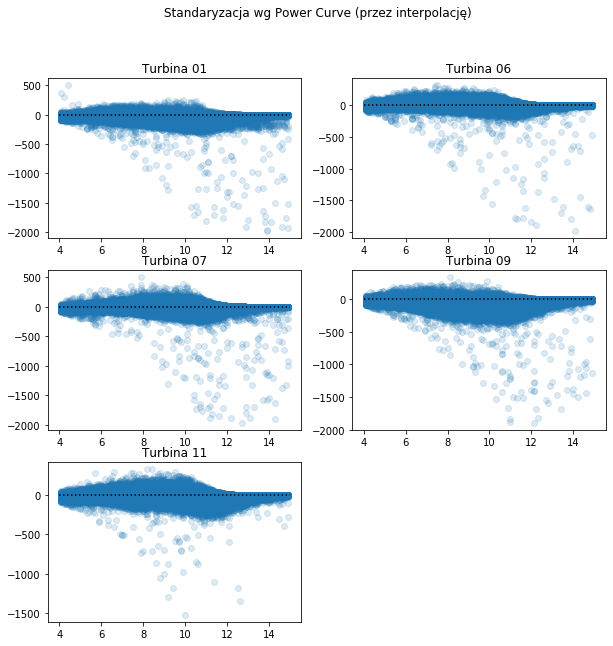

In [7]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve (przez interpolację)')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Std, alpha=0.15)
ax[0,0].set_title("Turbina 01")
ax[0,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Std, alpha=0.15)
ax[0,1].set_title("Turbina 06")
ax[0,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Std, alpha=0.15)
ax[1,0].set_title("Turbina 07")
ax[1,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Std, alpha=0.15)
ax[1,1].set_title("Turbina 09")
ax[1,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Std, alpha=0.15)
ax[2,0].set_title("Turbina 11")
ax[2,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,1].set_axis_off()
plt.show()

### Standaryzacja 2. 

Ciągłe przybliżenie power curve za pomocą funkcji sigmoidalnej.

Funkcja sigmoidalna to funkcja postaci $$y(x)=L/(1 + e^{-k (x - x_0)}) + b,$$ gdzie $L$, $k$, $x_0$ oraz $b$ są parametrami.

In [8]:
# Funkcja sigmoidalna:
def sigmoid_curve(x, L, x_0, k, b):
    return L / (1 + np.exp(-k * (x - x_0))) + b

x_data = Power_curve.index
y_data = Power_curve.iloc[:, 0]

# Estymacja parametrów L, x_0, k, b:
init_state = [max(y_data), np.median(x_data), 1, min(y_data)]
popt, pcov = curve_fit(sigmoid_curve, x_data, y_data, method="dogbox")
popt

array([1.91136823e+03, 8.37590241e+00, 8.37235051e-01, 9.92345945e+01])

In [9]:
# Sigmoidalne przybliżenie 
def power_curve2(x):
    return 1911.36823 / (1 + np.exp(-0.83735044 * (x - 8.3759024))) + 99.92345886

def std_power_curve2(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Sigm"] = turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] - power_curve2(turbine_new.loc[:,"Amb_WindSpeed_Avg"])
    return turbine_new

signals_T01_std = std_power_curve2(signals_T01_std)
signals_T06_std = std_power_curve2(signals_T06_std)
signals_T07_std = std_power_curve2(signals_T07_std)
signals_T09_std = std_power_curve2(signals_T09_std)
signals_T11_std = std_power_curve2(signals_T11_std)

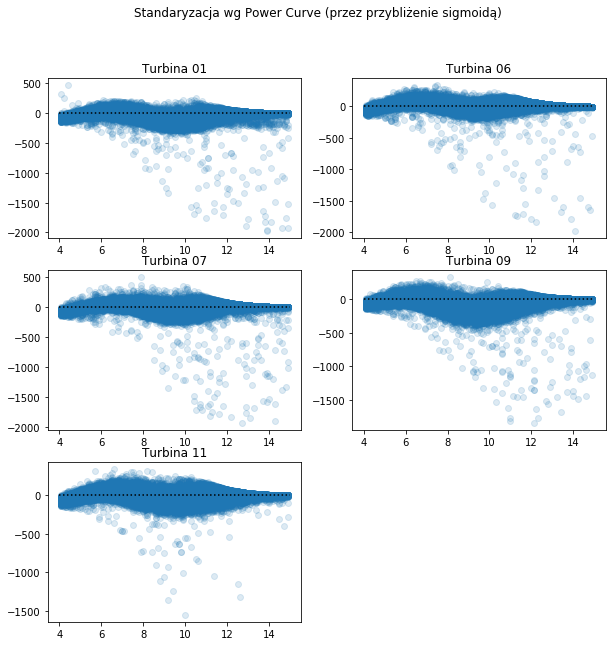

In [10]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve (przez przybliżenie sigmoidą)')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Sigm, alpha=0.15)
ax[0,0].set_title("Turbina 01")
ax[0,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Sigm, alpha=0.15)
ax[0,1].set_title("Turbina 06")
ax[0,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Sigm, alpha=0.15)
ax[1,0].set_title("Turbina 07")
ax[1,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Sigm, alpha=0.15)
ax[1,1].set_title("Turbina 09")
ax[1,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Sigm, alpha=0.15)
ax[2,0].set_title("Turbina 11")
ax[2,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,1].set_axis_off()
plt.show()

Porównanie przybliżeń za pomocą sigmoidy oraz interpolacji liniowej

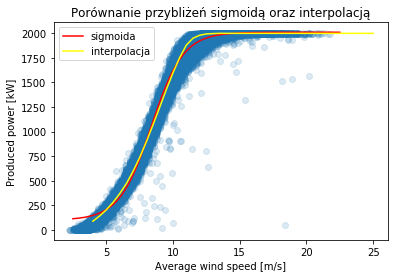

In [11]:
plt.scatter(signals_T11.Amb_WindSpeed_Avg, signals_T11.Grd_Prod_Pwr_Avg, alpha=0.15)
plt.plot(np.linspace(2.5, 22.5, 1000), power_curve2(np.linspace(2.5, 22.5, 1000)), color="red", label="sigmoida")
plt.plot(Power_curve, color='yellow', label="interpolacja")
plt.xlabel("Average wind speed [m/s]")
plt.ylabel("Produced power [kW]")
plt.title("Porównanie przybliżeń sigmoidą oraz interpolacją")
plt.legend()
plt.show()

### Standaryzacja 3.

Standaryzacja opisana jest wzorem $$\text{Pwr_std}=1-\text{Pwr_Gen}/\text{Pwr_Theo},$$ gdzie $\text{Pwr_Gen}$ to generowany prąd, a $\text{Pwr_Theo}$ to teoretyczna wartość prądu dla tej samej prędkości wiatru. Przy takiej standaryzacji wartości bliskie 0 oznaczają idealną pracę zgodną z teoretyczną krzywą, wartości dodatnie oznaczają pracą gorszą niż teoretyczna (mniejszy generowany prąd), a wartości ujemne pracę lepszą niż teoretyczna (większy generowany prąd).

In [12]:
def std_power_curve3(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new.loc[:,"Pwr_Ratio"] = 1 - (turbine_new.loc[:,"Grd_Prod_Pwr_Avg"] / power_curve1(turbine_new.loc[:,"Amb_WindSpeed_Avg"]))
    return turbine_new

signals_T01_std = std_power_curve3(signals_T01_std)
signals_T06_std = std_power_curve3(signals_T06_std)
signals_T07_std = std_power_curve3(signals_T07_std)
signals_T09_std = std_power_curve3(signals_T09_std)
signals_T11_std = std_power_curve3(signals_T11_std)

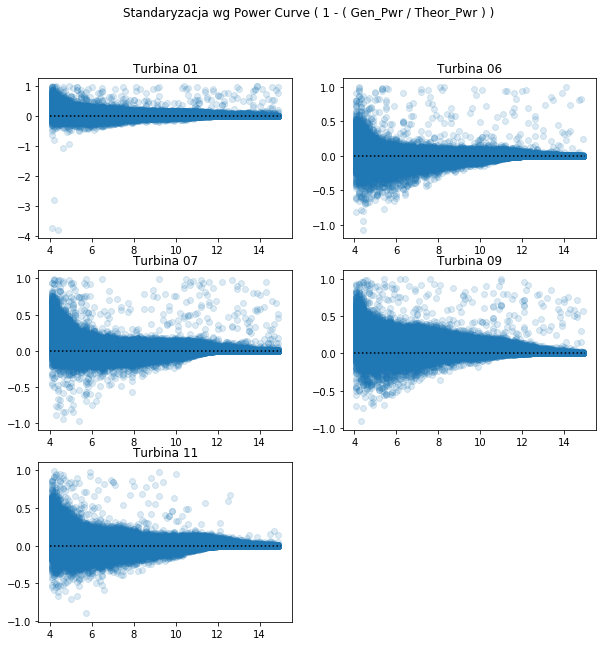

In [13]:
fig, ax = plt.subplots(3,2, figsize=(10,10))
fig.suptitle('Standaryzacja wg Power Curve ( 1 - ( Gen_Pwr / Theor_Pwr ) )')

ax[0,0].scatter(signals_T01_std.Amb_WindSpeed_Avg, signals_T01_std.Pwr_Ratio, alpha=0.15)
ax[0,0].set_title("Turbina 01")
ax[0,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[0,1].scatter(signals_T06_std.Amb_WindSpeed_Avg, signals_T06_std.Pwr_Ratio, alpha=0.15)
ax[0,1].set_title("Turbina 06")
ax[0,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,0].scatter(signals_T07_std.Amb_WindSpeed_Avg, signals_T07_std.Pwr_Ratio, alpha=0.15)
ax[1,0].set_title("Turbina 07")
ax[1,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[1,1].scatter(signals_T09_std.Amb_WindSpeed_Avg, signals_T09_std.Pwr_Ratio, alpha=0.15)
ax[1,1].set_title("Turbina 09")
ax[1,1].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,0].scatter(signals_T11_std.Amb_WindSpeed_Avg, signals_T11_std.Pwr_Ratio, alpha=0.15)
ax[2,0].set_title("Turbina 11")
ax[2,0].hlines(y=0, xmin=4, xmax=15, linestyles="dotted")

ax[2,1].set_axis_off()
plt.show()